## Sumário
1. [Bruto](#bruto)
    * [Linear](#linear-bruto)
    * [Linear Ridge regression](#linear-ridge)
    * [SVR](#SVR-bruto)
    * [Random Forrest](#Rforest-bruto)
2. [TPOT](#TPOT)

In [1]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 55 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   defect_type         880 non-null    object 
 1   rot_vel             880 non-null    float64
 2   ac1ax_0h            880 non-null    float64
 3   ac1ax_1h            880 non-null    float64
 4   ac1ax_2h            880 non-null    float64
 5   ac1ax_3h            880 non-null    float64
 6   ac1ax_entropy       880 non-null    float64
 7   ac1ax_kurt          880 non-null    float64
 8   ac1ax_mean          880 non-null    float64
 9   ac1rad_0h           880 non-null    float64
 10  ac1rad_1h           880 non-null    float64
 11  ac1rad_2h           880 non-null    float64
 12  ac1rad_3h           880 non-null    float64
 13  ac1rad_entropy      880 non-null    float64
 14  ac1rad_kurt         880 non-null    float64
 15  ac1rad_mean         880 non-null    float64
 16  ac1tg_0h

In [3]:
# lista com os tipos de defeito para cada índice
# será útil na divisão de grupos de Treino e de Teste usando AMOSTRAGEM ESTRATIFICADA por tipo de defeito
faults = df['defect_type'].to_list()

['normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor_mis',
 'hor

## Considerações
* A base de dados conta com classificações de defeito disjuntas. Assim, quando o defeito não foi provocado, será assumido o valor de 0 para o defeito
* O valor 'fundamental' extraído do tacômetro representa melhor a velocidade do rotor do que o valor fornecido pela base, daí `drop('rot_vel')`

In [4]:
df = df.fillna(0)
df = df.drop('defect_type', axis=1)
df = df.drop('rot_vel', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ac1ax_0h            880 non-null    float64
 1   ac1ax_1h            880 non-null    float64
 2   ac1ax_2h            880 non-null    float64
 3   ac1ax_3h            880 non-null    float64
 4   ac1ax_entropy       880 non-null    float64
 5   ac1ax_kurt          880 non-null    float64
 6   ac1ax_mean          880 non-null    float64
 7   ac1rad_0h           880 non-null    float64
 8   ac1rad_1h           880 non-null    float64
 9   ac1rad_2h           880 non-null    float64
 10  ac1rad_3h           880 non-null    float64
 11  ac1rad_entropy      880 non-null    float64
 12  ac1rad_kurt         880 non-null    float64
 13  ac1rad_mean         880 non-null    float64
 14  ac1tg_0h            880 non-null    float64
 15  ac1tg_1h            880 non-null    float64
 16  ac1tg_2h

In [5]:
df

,ac1ax_0h,ac1ax_1h,ac1ax_2h,ac1ax_3h,ac1ax_entropy,ac1ax_kurt,ac1ax_mean,ac1rad_0h,ac1rad_1h,ac1rad_2h,...,microphone_0h,microphone_1h,microphone_2h,microphone_3h,microphone_entropy,microphone_kurt,microphone_mean,hor_mis,ver_mis,imbalance
0,0.023855,0.511270,0.988045,1.339176,1.772458,-0.635742,0.000337,0.033415,3.923985,0.504539,...,0.551081,0.551457,0.115004,0.460503,0.865150,0.007800,0.007793,0.0,0.0,0.0
1,0.046567,0.613266,0.965089,0.573923,1.783026,-0.736877,-0.000659,1.437172,6.146448,1.866470,...,0.514495,0.640527,0.181211,0.697675,0.890467,0.261131,0.007276,0.0,0.0,0.0
2,0.017612,0.529154,1.284498,0.276121,1.770020,-0.622437,-0.000249,3.650354,4.890820,1.970451,...,1.215805,0.572169,0.159304,0.510432,0.986914,0.099437,0.017194,0.0,0.0,0.0
3,0.085377,0.592791,1.007594,0.423454,1.791199,-0.620533,-0.001207,1.869813,5.879474,1.437882,...,1.371201,0.694510,0.170248,0.733444,1.004580,-0.032006,0.019392,0.0,0.0,0.0
4,0.079136,0.908270,1.020371,0.656523,1.852396,-0.569673,-0.001119,0.497732,4.688242,0.700706,...,1.040568,0.615031,0.174614,0.667590,0.952025,-0.007593,0.014716,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,0.087657,26.795504,1.096053,2.674881,2.786962,0.449189,0.001240,0.127466,10.369050,0.828607,...,0.937906,1.032893,0.245817,0.709930,1.494299,-0.417936,0.013264,0.0,0.0,6.0
876,0.237895,29.047549,1.385651,2.420160,2.800365,0.138570,-0.003364,0.034476,11.195524,0.951217,...,0.918921,1.040474,0.234535,0.666452,1.498213,-0.474776,0.012996,0.0,0.0,6.0
877,0.241285,28.346135,1.746965,2.846865,2.803833,0.010857,0.003412,0.140910,11.428311,7.362720,...,0.962782,1.053660,0.423161,0.706543,1.498696,-0.545511,0.013616,0.0,0.0,6.0
878,0.688955,29.910435,0.953741,2.964910,2.848820,0.161433,0.009743,0.110657,12.331951,6.839862,...,0.915267,1.021583,0.326754,0.717217,1.493465,-0.519746,0.012944,0.0,0.0,6.0


# Regrassão bruta total (todas as características x todos os sinais) <a class="anchor" id="bruto"></a>

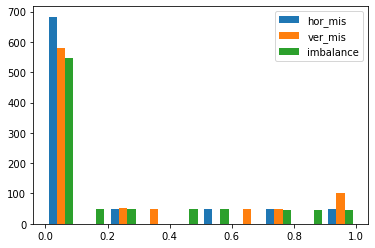

In [6]:
from sklearn.preprocessing import minmax_scale

fault_list = ['hor_mis', 'ver_mis', 'imbalance']

# armazenando os labels em um array
labels = np.array(df[fault_list])

# salvando a ordem das features
feature_list = list(df.columns)

labels = minmax_scale(labels)

plt.hist(labels)
# plt.title('Frequência da populaçao')
plt.legend(fault_list)
plt.show()

In [7]:
# removendo a coluna de labels do df original
df = df.drop(['hor_mis', 'ver_mis', 'imbalance'], axis = 1)

# check
df.columns

Index(['ac1ax_0h', 'ac1ax_1h', 'ac1ax_2h', 'ac1ax_3h', 'ac1ax_entropy',
       'ac1ax_kurt', 'ac1ax_mean', 'ac1rad_0h', 'ac1rad_1h', 'ac1rad_2h',
       'ac1rad_3h', 'ac1rad_entropy', 'ac1rad_kurt', 'ac1rad_mean', 'ac1tg_0h',
       'ac1tg_1h', 'ac1tg_2h', 'ac1tg_3h', 'ac1tg_entropy', 'ac1tg_kurt',
       'ac1tg_mean', 'ac2ax_0h', 'ac2ax_1h', 'ac2ax_2h', 'ac2ax_3h',
       'ac2ax_entropy', 'ac2ax_kurt', 'ac2ax_mean', 'ac2rad_0h', 'ac2rad_1h',
       'ac2rad_2h', 'ac2rad_3h', 'ac2rad_entropy', 'ac2rad_kurt',
       'ac2rad_mean', 'ac2tg_0h', 'ac2tg_1h', 'ac2tg_2h', 'ac2tg_3h',
       'ac2tg_entropy', 'ac2tg_kurt', 'ac2tg_mean', 'fundamental',
       'microphone_0h', 'microphone_1h', 'microphone_2h', 'microphone_3h',
       'microphone_entropy', 'microphone_kurt', 'microphone_mean'],
      dtype='object')

In [8]:
# convertendo df para array
data = np.array(df)

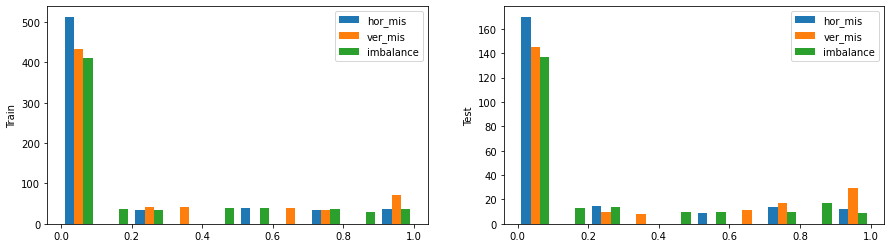

In [9]:
# importar train_test_split do scikitlearn 
from sklearn.model_selection import train_test_split

# aplicando a funcao train_test_split para separar os conjuntos de treino e 
# teste segundo uma porcentagem de separação definida. 
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.25, stratify = faults)

fig, axs = plt.subplots(1,2, figsize = (15,4))
axs[0].hist(train_labels)
axs[0].set_ylabel('Frequência conjunto treino')
axs[0].legend(fault_list)
axs[1].hist(test_labels)
axs[1].set_ylabel('Frequência conjunto teste')
axs[1].legend(fault_list)
plt.show()

## Regressão linear <a class="anchor" id="linear-bruto"></a>

In [10]:
# importar o modelo de regressão linear
from sklearn.linear_model import LinearRegression 

# treinando o modelo no conjunto de dados de treino
regression = LinearRegression().fit(train_data, train_labels);

In [11]:
# aplicando o modelo treinado para a previsão da temperatura 
#em todo o conjunto de teste
prediction_labels = regression.predict(test_data)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
p1 = pd.DataFrame({'Real': test_labels.tolist(), 'Previsto': prediction_labels.tolist()})
p1['Norma do erro'] = p1.apply(lambda x: np.linalg.norm(np.array(x.Real) - np.array(x.Previsto)), axis=1)

# p1.head(10)

### *Colorizar com velocidades*

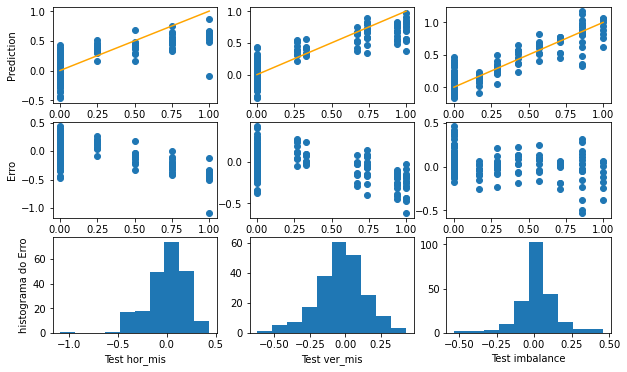

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(10,6))

axs[0,0].set_ylabel('Prediction')
axs[1,0].set_ylabel('Erro')
axs[2,0].set_ylabel('histograma do Erro')

for i, fault in enumerate(['hor_mis', 'ver_mis', 'imbalance']):
    axs[0,i].scatter(x=test_labels[:,i], y=prediction_labels[:,i])
    axs[0,i].plot([0,1],[0,1],'orange')
#     axs[1,i].scatter(x=test_labels[:,i], y=prediction_labels[:,i]-test_labels[:,i])
    axs[2,i].hist(prediction_labels[:,i] - test_labels[:,i])
    axs[2,i].set_xlabel('Test ' + fault)  

plt.show()

In [13]:
import sklearn.metrics as metrics

#avaliando o modelo
# for i, fault in enumerate(['hor_mis', 'ver_mis', 'imbalance']):
#     print('\nMétricas para', fault)
#     print('R2:', metrics.r2_score(test_labels[i], prediction_labels[i]))
#     print('MSE:', metrics.mean_squared_error(test_labels[i], prediction_labels[i]))  
#     print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels[i], prediction_labels[i])))
#     print('MAE:', metrics.mean_absolute_error(test_labels[i], prediction_labels[i]))


iterables = [['Regressão Linear'], ['hor_mis', 'ver_mis', 'imbalance']]
columns = pd.MultiIndex.from_product(iterables, names=['Modelo', 'Falha'])

metric = np.zeros((4,3))
for col in range(3):
    metric[:,col] = np.array([metrics.r2_score(test_labels[:,col], prediction_labels[:,col]), 
                              metrics.mean_squared_error(test_labels[:,col], prediction_labels[:,col]),
                              np.sqrt(metrics.mean_squared_error(test_labels[:,col], prediction_labels[:,col])),
                              metrics.mean_absolute_error(test_labels[:,col], prediction_labels[:,col])])

results = pd.DataFrame(metric, index=['R2', 'MSE', 'RMSE', 'MAE'], columns=columns)
results

Modelo Regressão Linear                    
Falha           hor_mis   ver_mis imbalance
R2             0.509174  0.786785  0.835002
MSE            0.041864  0.029086  0.017401
RMSE           0.204607  0.170547  0.131915
MAE            0.154937  0.129750  0.089755

### Conclusão
?

## Linear Ridge Regressor <a class="anchor" id="linear-ridge"></a>


In [26]:
# importar o modelo de regressão linear
from sklearn.linear_model import Ridge

# treinando o modelo no conjunto de dados de treino
regression = Ridge().fit(train_data, train_labels);

In [ ]:
# aplicando o modelo treinado para a previsão da temperatura 
#em todo o conjunto de teste
prediction_labels = regression.predict(test_data)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
p1 = pd.DataFrame({'Real': test_labels.tolist(), 'Previsto': prediction_labels.tolist()})
p1['Norma do erro'] = p1.apply(lambda x: np.linalg.norm(np.array(x.Real) - np.array(x.Previsto)), axis=1)

# p1.head(10)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10,6))

axs[0,0].set_ylabel('Prediction')
axs[1,0].set_ylabel('Erro')
axs[2,0].set_ylabel('histograma do Erro')

for i, fault in enumerate(['hor_mis', 'ver_mis', 'imbalance']):
    axs[0,i].scatter(x=test_labels[:,i], y=prediction_labels[:,i])
    axs[0,i].plot([0,1],[0,1],'orange')
    axs[1,i].scatter(x=test_labels[:,i], y=prediction_labels[:,i]-test_labels[:,i])
    axs[2,i].hist(prediction_labels[:,i] - test_labels[:,i])
    axs[2,i].set_xlabel('Test ' + fault)  

plt.show()

In [ ]:
import sklearn.metrics as metrics

iterables = [['Regressão Linear'], ['hor_mis', 'ver_mis', 'imbalance']]
columns = pd.MultiIndex.from_product(iterables, names=['Modelo', 'Falha'])

metric = np.zeros((4,3))
for col in range(3):
    metric[:,col] = np.array([metrics.r2_score(test_labels[:,col], prediction_labels[:,col]), 
                              metrics.mean_squared_error(test_labels[:,col], prediction_labels[:,col]),
                              np.sqrt(metrics.mean_squared_error(test_labels[:,col], prediction_labels[:,col])),
                              metrics.mean_absolute_error(test_labels[:,col], prediction_labels[:,col])])

results = pd.DataFrame(metric, index=['R2', 'MSE', 'RMSE', 'MAE'], columns=columns)
results

## Support Vector Regressor SVR <a class="anchor" id="SVR-bruto"></a>

In [14]:
# #importar o modelo SVR
# from sklearn.svm import SVR

# # instanciacao e determinacao dos hiperparâmetros do SVR: tipo de kernel e epsilon
# regression = SVR(kernel='rbf', epsilon=1.0)

# # treinando o SVR
# regression.fit(train_data,train_labels)

## Random Forest Regressor <a class="anchor" id="Rforest-bruto"></a>


In [15]:
# importar o modelo Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# treinando o modelo 
regression = RandomForestRegressor(n_estimators= 10, random_state=42).fit(train_data, train_labels);

In [16]:
# aplicando o modelo treinado para a previsão da temperatura 
#em todo o conjunto de teste
prediction_labels = regression.predict(test_data)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
p1 = pd.DataFrame({'Real': test_labels.tolist(), 'Previsto': prediction_labels.tolist()})
p1['Norma do erro'] = p1.apply(lambda x: np.linalg.norm(np.array(x.Real) - np.array(x.Previsto)), axis=1)

# p1.head(10)

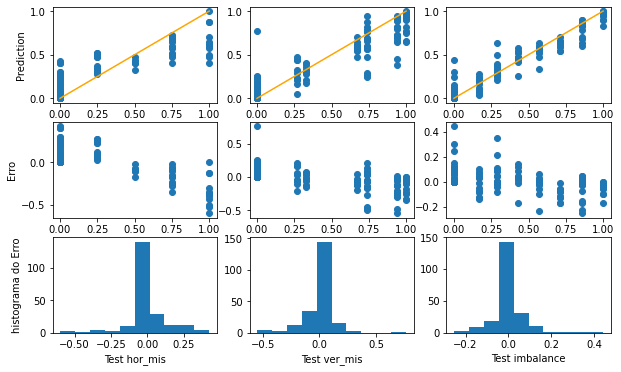

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(10,6))

axs[0,0].set_ylabel('Prediction')
axs[1,0].set_ylabel('Erro')
axs[2,0].set_ylabel('histograma do Erro')

for i, fault in enumerate(['hor_mis', 'ver_mis', 'imbalance']):
    axs[0,i].scatter(x=test_labels[:,i], y=prediction_labels[:,i])
    axs[0,i].plot([0,1],[0,1],'orange')
    axs[1,i].scatter(x=test_labels[:,i], y=prediction_labels[:,i]-test_labels[:,i])
    axs[2,i].hist(prediction_labels[:,i] - test_labels[:,i])
    axs[2,i].set_xlabel('Test ' + fault)  

plt.show()

In [18]:
#avaliando o modelo
# for i, fault in enumerate(['hor_mis', 'ver_mis', 'imbalance']):
#     print('\nMétricas para', fault)
#     print('R2:', metrics.r2_score(test_labels[i], prediction_labels[i]))
#     print('MSE:', metrics.mean_squared_error(test_labels[i], prediction_labels[i]))  
#     print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels[i], prediction_labels[i])))
#     print('MAE:', metrics.mean_absolute_error(test_labels[i], prediction_labels[i]))


iterables = [['Random Forrest'], ['hor_mis', 'ver_mis', 'imbalance']]
columns = pd.MultiIndex.from_product(iterables, names=['Modelo', 'Falha'])

metric = np.zeros((4,3))
for col in range(3):
    metric[:,col] = np.array([metrics.r2_score(test_labels[:,col], prediction_labels[:,col]), 
                              metrics.mean_squared_error(test_labels[:,col], prediction_labels[:,col]),
                              np.sqrt(metrics.mean_squared_error(test_labels[:,col], prediction_labels[:,col])),
                              metrics.mean_absolute_error(test_labels[:,col], prediction_labels[:,col])])

results = pd.DataFrame(metric, index=['R2', 'MSE', 'RMSE', 'MAE'], columns=columns)
results

Modelo Random Forrest                    
Falha         hor_mis   ver_mis imbalance
R2           0.771410  0.874931  0.945435
MSE          0.019497  0.017062  0.005755
RMSE         0.139632  0.130620  0.075860
MAE          0.071932  0.065785  0.038169

# TPOT <a class="anchor" id="TPOT"></a>

In [ ]:
# impede a reexecução do TPOT.. que pode levar horas, dias..
# pressionar “n” e Enter ou "c" continua a execução 
# pressionar “q” interrompe a execução
%debug

In [19]:
from tpot import TPOTRegressor

C:\Users\renne\anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [23]:
pipeline_optimizer_hor_mis = TPOTRegressor()

In [25]:
pipeline_optimizer_hor_mis.fit(train_data, train_labels[:,0])

TPOTRegressor()

In [28]:
 print(pipeline_optimizer_hor_mis.score(test_data, test_labels[:,0]))

-0.004098855290908725


In [29]:
pipeline_optimizer_hor_mis.export('tpot_pipeline_hor_mis.py')

In [31]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import StackingEstimator

# Average CV score on the training set was: -0.009330433709391846
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    StackingEstimator(estimator=AdaBoostRegressor(learning_rate=1.0, loss="exponential", n_estimators=100)),
    RandomForestRegressor(bootstrap=False, max_features=0.4, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
)

exported_pipeline.fit(train_data, train_labels[:,0])
results = exported_pipeline.predict(test_data)


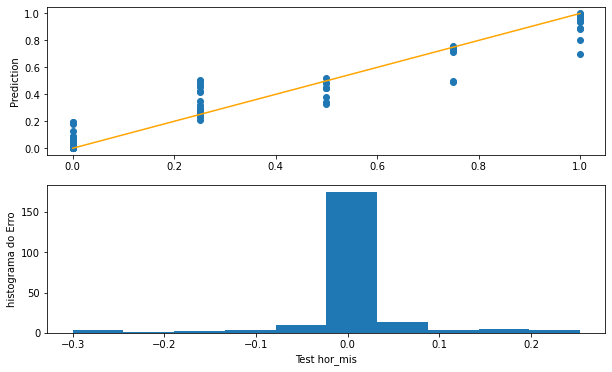

In [35]:

fig, axs = plt.subplots(2, 1, figsize=(10,6))

axs[0].set_ylabel('Prediction')
axs[1].set_ylabel('histograma do Erro')

axs[0].scatter(x=test_labels[:,i], y=results)
axs[0].plot([0,1],[0,1],'orange')
axs[1].hist(results - test_labels[:,i])
axs[1].set_xlabel('Test ' + fault)  

plt.show()

In [40]:
# avaliando o modelo

print('R2:', metrics.r2_score(test_labels[:,0], results))
print('MSE:', metrics.mean_squared_error(test_labels[:,0], results))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels[:,0], results)))
print('MAE:', metrics.mean_absolute_error(test_labels[:,0], results))


R2: 0.9549531485359932
MSE: 0.0038421869654559817
RMSE: 0.061985377029231514
MAE: 0.026233573150334512
